In [1]:
import os
import time
import uuid
import cv2
import albumentations as alb

In [9]:
!labelme

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img


In [42]:
import albumentations as alb

augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5),
    alb.Rotate(limit=30, p=0.5),
    alb.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
    alb.RandomResizedCrop(height=450, width=450, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), p=0.5),
    alb.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    alb.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    alb.MotionBlur(blur_limit=3, p=0.5),
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))


In [43]:
for image in os.listdir(os.path.join('Data','Images')):
    img = cv2.imread(os.path.join('Data', 'Images', image))

    height, width, channels = img.shape
    coords = [0,0,0.00001,0.00001]
    label_path = os.path.join('Data', 'Labels', f'{image.split(".")[0]}.json')
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label = json.load(f)

        coords[0] = label['shapes'][0]['points'][0][0]
        coords[1] = label['shapes'][0]['points'][0][1]
        coords[2] = label['shapes'][0]['points'][1][0]
        coords[3] = label['shapes'][0]['points'][1][1]
        coords = list(np.divide(coords, [width,height,width,height]))

    try: 
        for x in range(80):
            augmented = augmentor(image=img, bboxes=[coords], class_labels=['Bowie'])
            cv2.imwrite(os.path.join('aug_data', 'Images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

            annotation = {}
            annotation['image'] = image

            if os.path.exists(label_path):
                if len(augmented['bboxes']) == 0: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
                else: 
                    annotation['bbox'] = augmented['bboxes'][0]
                    annotation['class'] = 1
            else: 
                annotation['bbox'] = [0,0,0,0]
                annotation['class'] = 0 


            with open(os.path.join('aug_data', 'Labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                json.dump(annotation, f)

    except Exception as e:
        print(e)


IndexError: list index out of range

In [14]:
images = tf.data.Dataset.list_files(['aug_data\\Images\\*.jpg', 'aug_data\\Images\\*.jpeg'], shuffle=False)
labels = tf.data.Dataset.list_files(['aug_data\\Labels\\*.json'], shuffle=False)

In [15]:
images = list(images.as_numpy_iterator())
labels = list(labels.as_numpy_iterator())

In [16]:
train_images, temp_test_data, train_labels, temp_test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(temp_test_data, temp_test_labels, test_size=0.3, random_state=42)

In [17]:
train_images = tf.data.Dataset.from_tensor_slices(train_images)
train_labels = tf.data.Dataset.from_tensor_slices(train_labels)
test_images = tf.data.Dataset.from_tensor_slices(test_images)
test_labels = tf.data.Dataset.from_tensor_slices(test_labels)
val_images = tf.data.Dataset.from_tensor_slices(val_images)
val_labels = tf.data.Dataset.from_tensor_slices(val_labels)

In [18]:
h,w = 224, 224

In [19]:
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (w,h)))
train_images = train_images.map(lambda x: x/255)

In [20]:
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (w,h)))
test_images = test_images.map(lambda x: x/255)

In [21]:
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (w,h)))
val_images = val_images.map(lambda x: x/255)

In [22]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [23]:
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [24]:
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [25]:
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [26]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4544, 4544, 795, 795, 341, 341)

In [27]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(32)
train = train.prefetch(4)

In [28]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(32)
test = test.prefetch(4)

In [29]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(32)
val = val.prefetch(4)

In [30]:
data_samples = train.as_numpy_iterator()

In [31]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


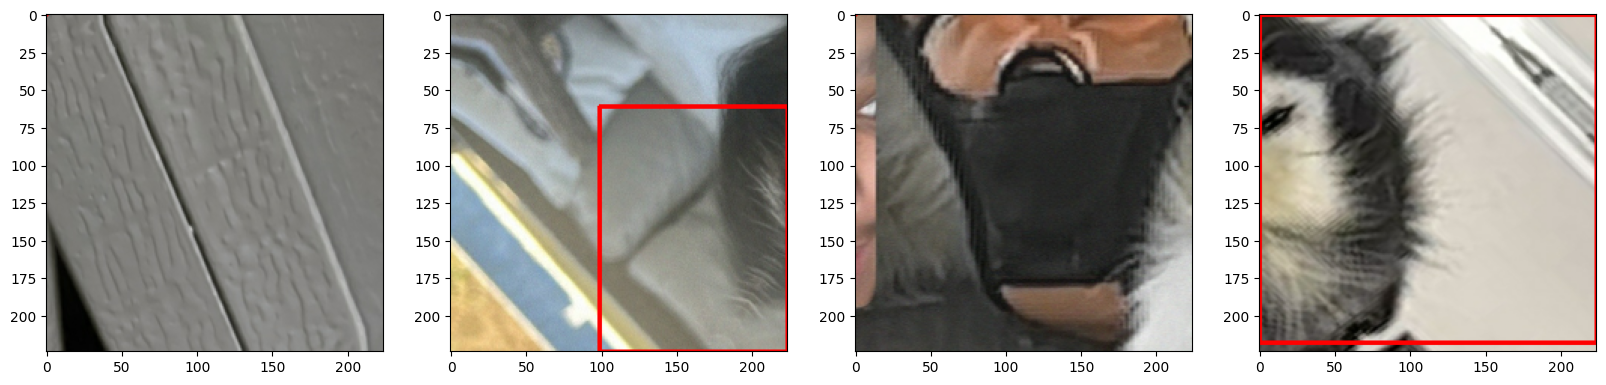

In [32]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [w,h]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [w,h]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

In [34]:
vgg = VGG16(include_top=False)

<h1>Changed VGG16 to ResNet and added batch Normalization<h1>

In [35]:
def build_model(): 
    input_layer = Input(shape=(w, h, 3))
    
    resnet = ResNet50(include_top=False, input_tensor=input_layer)
    
    # Classification Model  
    f1 = GlobalMaxPooling2D()(resnet.output)
    class1 = Dense(2048, activation='relu', kernel_regularizer=l2(0.01))(f1)
    class1_bn = BatchNormalization()(class1)
    class2 = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(class1_bn)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(resnet.output)
    regress1 = Dense(2048, activation='relu', kernel_regularizer=l2(0.01))(f2)
    regress1_bn = BatchNormalization()(regress1)
    regress2 = Dense(4, activation='sigmoid', kernel_regularizer=l2(0.01))(regress1_bn)
    
    bowietracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return bowietracker


In [36]:
bowietracker = build_model()

In [37]:
bowietracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [38]:
X, y = train.as_numpy_iterator().next()

In [39]:
X.shape

(32, 224, 224, 3)

In [40]:
classes, coords = bowietracker.predict(X)

1/1 [==============================] - 3s 3s/step


In [41]:
classes, coords

(array([[0.07511065],
        [0.07582549],
        [0.07923015],
        [0.06580618],
        [0.07719608],
        [0.07068187],
        [0.0725049 ],
        [0.06489674],
        [0.06406794],
        [0.06515528],
        [0.06709533],
        [0.08297047],
        [0.06723788],
        [0.06883165],
        [0.07099391],
        [0.06644023],
        [0.08094221],
        [0.06497402],
        [0.06699596],
        [0.06687421],
        [0.07057671],
        [0.06649181],
        [0.06602478],
        [0.07395489],
        [0.06553414],
        [0.08031174],
        [0.08216251],
        [0.07262913],
        [0.06594135],
        [0.05969699],
        [0.07018666],
        [0.07274666]], dtype=float32),
 array([[0.84256107, 0.1048316 , 0.8178482 , 0.63573986],
        [0.84008217, 0.09347541, 0.85355693, 0.62924975],
        [0.7558653 , 0.09203541, 0.7993733 , 0.6767861 ],
        [0.80108315, 0.09808672, 0.8064555 , 0.673179  ],
        [0.79832125, 0.10133875, 0.82683873, 0.

In [42]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [43]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [44]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [45]:
def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

In [46]:
def iou_loss(y_true, y_pred):
    # Calculate the coordinates of the intersection rectangle
    xi1 = tf.maximum(y_true[:, 0], y_pred[:, 0])
    yi1 = tf.maximum(y_true[:, 1], y_pred[:, 1])
    xi2 = tf.minimum(y_true[:, 2], y_pred[:, 2])
    yi2 = tf.minimum(y_true[:, 3], y_pred[:, 3])

    # Calculate the area of the intersection rectangle
    intersection = tf.maximum(xi2 - xi1, 0) * tf.maximum(yi2 - yi1, 0)

    # Calculate the area of the ground truth and predicted rectangles
    true_area = (y_true[:, 2] - y_true[:, 0]) * (y_true[:, 3] - y_true[:, 1])
    pred_area = (y_pred[:, 2] - y_pred[:, 0]) * (y_pred[:, 3] - y_pred[:, 1])

    # Calculate the IoU
    iou = intersection / (true_area + pred_area - intersection + 1e-6)

    # Return the IoU loss
    return 1 - tf.reduce_mean(iou)

In [47]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = l1_loss

In [48]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=40.005463>

In [49]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.530151>

In [50]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=0.45008016>

In [51]:
class BowieTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [52]:
model = BowieTracker(bowietracker)

In [53]:
from tensorflow.keras.callbacks import LearningRateScheduler
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch / step_size))
    
    return LearningRateScheduler(schedule)
lr_scheduler = step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10)


In [54]:
model.compile(opt, classloss, regressloss)

In [55]:
logdir='logs'

In [56]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [118]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_total_loss', patience=5, restore_best_weights=True)

In [120]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[lr_scheduler, early_stopping])

Epoch 1/15
142/142 [==============================] - 26s 155ms/step - total_loss: 0.0464 - class_loss: 0.0027 - regress_loss: 0.0451 - val_total_loss: 0.3825 - val_class_loss: 0.6004 - val_regress_loss: 0.0823 - lr: 0.0010
Epoch 2/15
142/142 [==============================] - 26s 154ms/step - total_loss: 0.0454 - class_loss: 0.0018 - regress_loss: 0.0445 - val_total_loss: 0.0985 - val_class_loss: 0.0554 - val_regress_loss: 0.0707 - lr: 0.0010
Epoch 3/15
142/142 [==============================] - 26s 153ms/step - total_loss: 0.0428 - class_loss: 7.7070e-04 - regress_loss: 0.0424 - val_total_loss: 0.1244 - val_class_loss: 0.0957 - val_regress_loss: 0.0766 - lr: 0.0010
Epoch 4/15
142/142 [==============================] - 26s 153ms/step - total_loss: 0.0436 - class_loss: 7.9241e-04 - regress_loss: 0.0432 - val_total_loss: 0.1331 - val_class_loss: 0.0852 - val_regress_loss: 0.0905 - lr: 0.0010
Epoch 5/15
142/142 [==============================] - 26s 155ms/step - total_loss: 0.0455 - clas

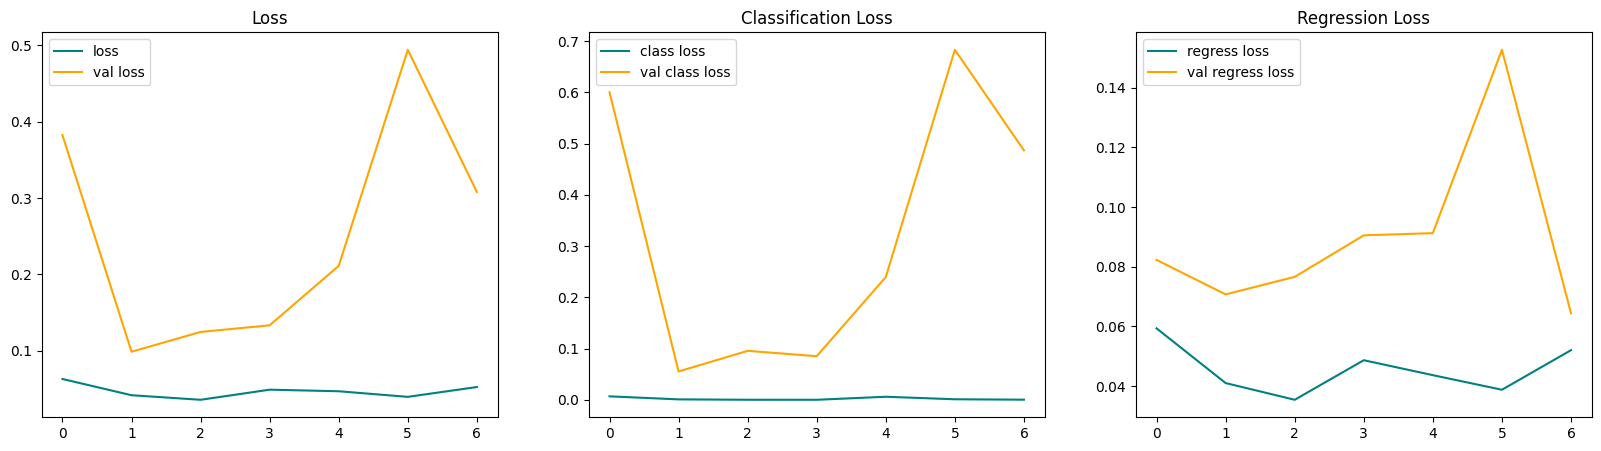

In [121]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [174]:
test_data = test.as_numpy_iterator()

In [175]:
test_sample = test_data.next()

In [176]:
yhat = bowietracker.predict(test_sample[0])

1/1 [==============================] - 0s 28ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


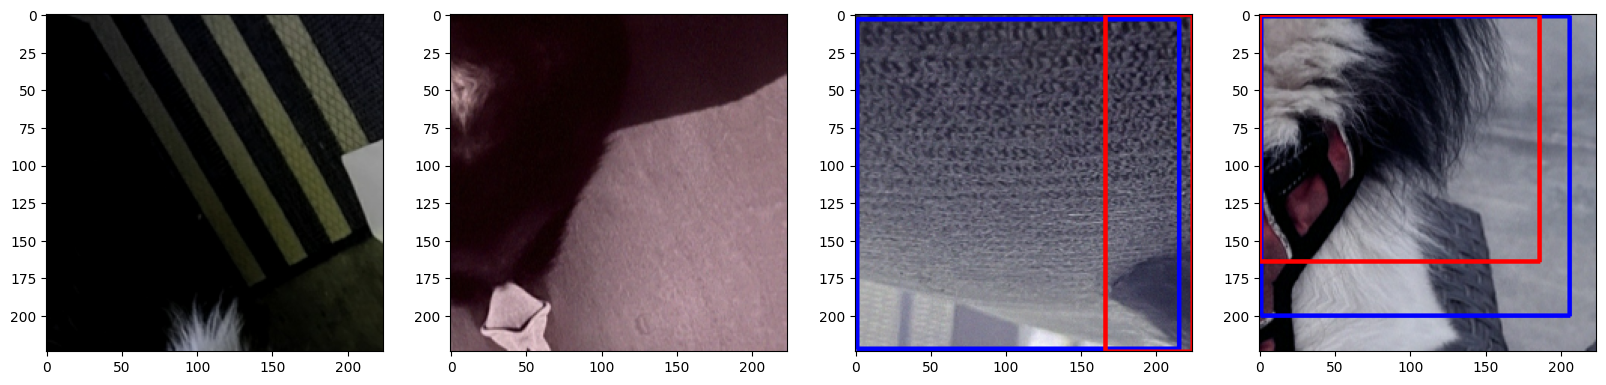

In [177]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    pred_coords = yhat[1][idx]
    true_coords = test_sample[1][1][idx]
    
    if yhat[0][idx] > 0.9:
        # Draw predicted bounding box in blue
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(pred_coords[:2], [w,h]).astype(int)),
                      tuple(np.multiply(pred_coords[2:], [w,h]).astype(int)), 
                            (0,0,255), 2)
        
        # Draw true bounding box in red
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(true_coords[:2], [w,h]).astype(int)),
                      tuple(np.multiply(true_coords[2:], [w,h]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [115]:
from tensorflow.keras.models import load_model
from IPython.display import clear_output

In [116]:
bowietracker.save('bowietrackerResNet_224x224_moreData.h5')

In [4]:
bowietracker = load_model('bowietrackerResNet.h5')

In [ ]:
!pip install opencv-python

In [266]:
import cv2

In [178]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (w,h))
    
    yhat = bowietracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.95: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Bowie', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('BowieTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step
